# <center> Period search in NGC 7793 P9's Swift light curve <center> 

In [1]:
import numpy as np
from stingray.pulse.search import epoch_folding_search, z_n_search
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
import pandas as pd
import hendrics 

/Users/alba/my_env/lib/python3.8/site-packages/stingray/largememory.py:25: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  warnings.warn(


In [2]:
from stingray.events import EventList
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
font_prop = font_manager.FontProperties(size=16)

## 1. Import data

In [3]:
lc= np.loadtxt('curve_plain.dat',comments='!',usecols=(0,1,2,3,4,5))

#upperlimits=pd.read_csv('upper.dat', sep='\s+',comment='!', engine='python',header=None) 

## 2. Define light curve object

In [4]:
times=lc[:,0]*(1/60)*1/60*1/24
counts=lc[:,3]
countrate_err=[lc[:,3],lc[:,4]]
lc1 = Lightcurve(times, counts,mjdref=55424,skip_checks=True,dt=0.05)


In [5]:
lc_cut = lc1.truncate(start=20, stop=800)

## 3. Plot lc

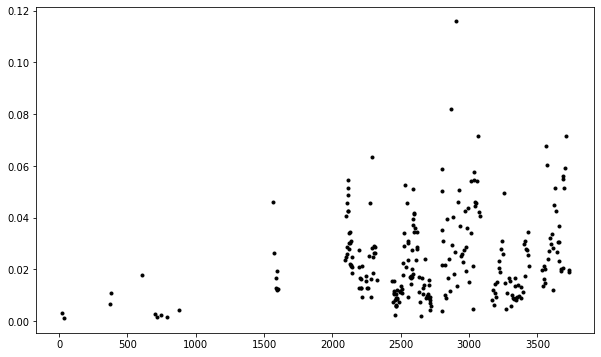

In [6]:
lc1.plot(marker = 'k.')

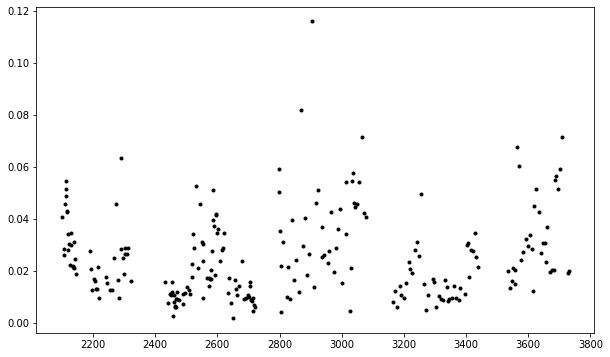

In [7]:
lc_cut.plot(marker = 'k.')

## 4. Find power spectrum

In [8]:
ps = Powerspectrum(lc_cut)
print(ps)

In [9]:
print("\nSize of positive Fourier frequencies:", len(ps.freq))
print("Number of data points per segment:", ps.n)


Size of positive Fourier frequencies: 119
Number of data points per segment: 240


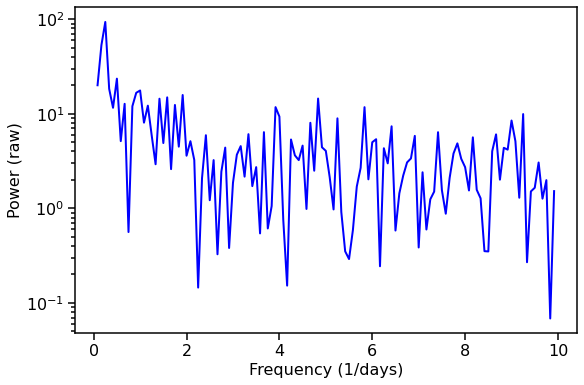

In [10]:
fig, ax1 = plt.subplots(1,1,figsize=(9,6), sharex=True)
ax1.plot(ps.freq, ps.power, lw=2, color='blue')
ax1.set_ylabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Power (raw)", fontproperties=font_prop)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
ax1.set_xlabel("Frequency (1/days)", fontproperties=font_prop)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()


In [11]:
avg_ps = AveragedPowerspectrum(lc_cut, 4)

3it [00:00, 620.86it/s]


In [12]:
print("Number of segments: %d" % avg_ps.m)

Number of segments: 3


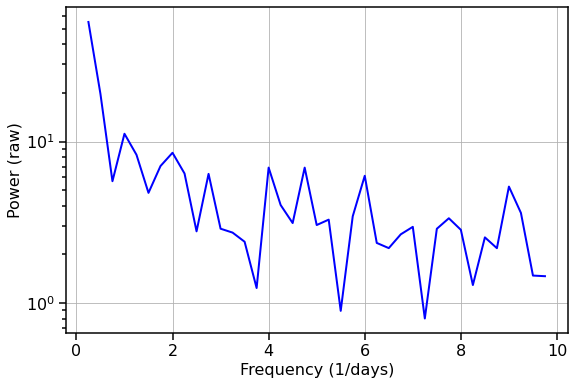

In [13]:
fig, ax1 = plt.subplots(1,1,figsize=(9,6))
ax1.plot(avg_ps.freq, avg_ps.power, lw=2, color='blue')
ax1.set_xlabel("Frequency (1/days)", fontproperties=font_prop)
ax1.set_ylabel("Power (raw)", fontproperties=font_prop)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
ax1.grid()
plt.show()


In [14]:
print(avg_ps.freq)

[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5
 3.75 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25 6.5  6.75 7.
 7.25 7.5  7.75 8.   8.25 8.5  8.75 9.   9.25 9.5  9.75]


## 5. Search of pulses

In [15]:
ev = EventList(lc_cut.time)
ev.time=ev.time 

In [16]:
period = 365



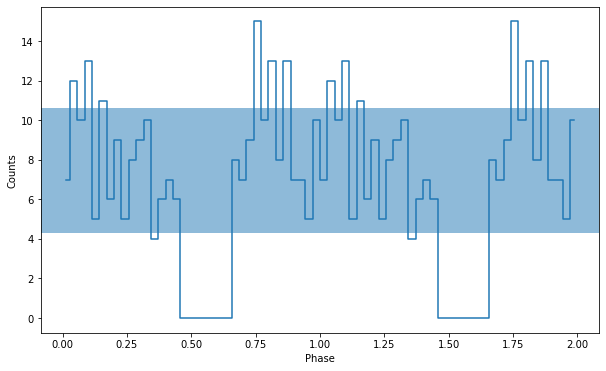

In [17]:
from stingray.pulse.pulsar import fold_events
from stingray.pulse.search import plot_profile
nbin = 35

ph, profile, profile_err = fold_events(ev.time , 1/period, nbin=nbin)
#ph1, profile1, profile_err1 = fold_events(ev.time , 1/410, nbin=nbin)



_ = plot_profile(ph, profile)
#_ = plot_profile(ph1, profile1)




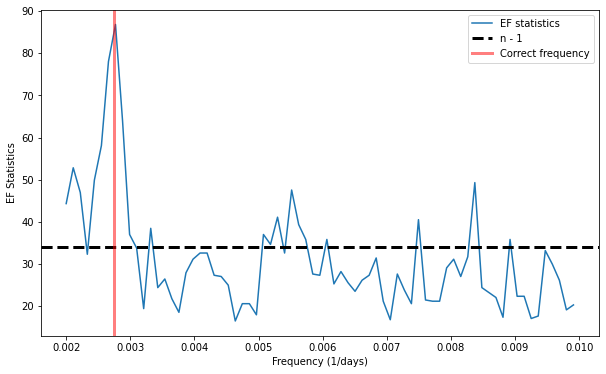

In [18]:
# We will search for pulsations over a range of frequencies around the known pulsation period.
obs_length=len(counts)
df_min = 1/obs_length
oversampling=35
df = df_min / oversampling
frequencies = np.arange(1/500, 0.01, df)

freq, efstat = epoch_folding_search(ev.time, frequencies, nbin=nbin)

# ---- PLOTTING --------
plt.figure()
plt.plot(freq, efstat, label='EF statistics')
plt.axhline(nbin - 1, ls='--', lw=3, color='k', label='n - 1')
plt.axvline(1/period, lw=3, alpha=0.5, color='r', label='Correct frequency')
plt.xlabel('Frequency (1/days)')
plt.ylabel('EF Statistics')
#plt.xlim(-0.001,0.001)
_ = plt.legend()

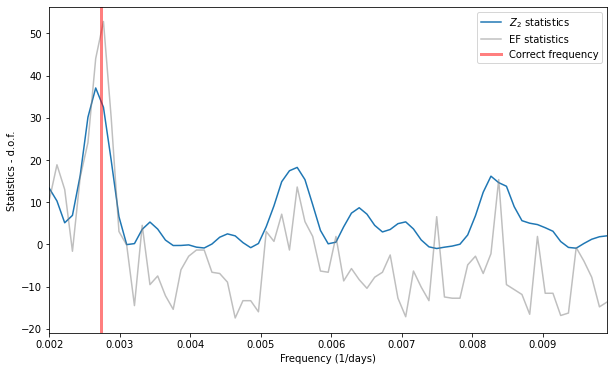

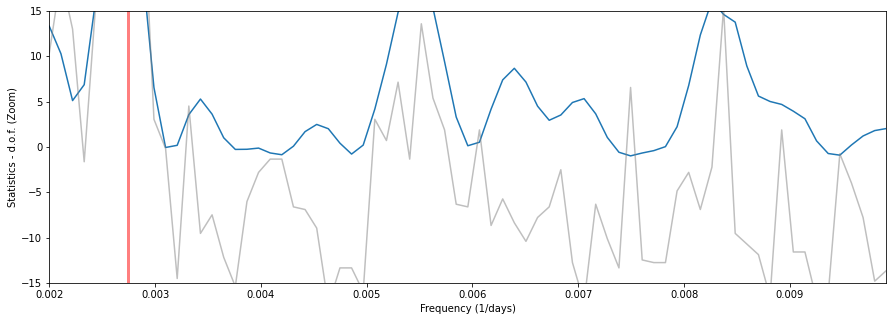

In [19]:
nharm = 1
freq, zstat = z_n_search(ev.time, frequencies, nbin=nbin, nharm=nharm,segment_size=5000)

# ---- PLOTTING --------
plt.figure()
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.xlim([frequencies[0], frequencies[-1]])
plt.xlabel('Frequency (1/days)')
plt.ylabel('Statistics - d.o.f.')
plt.legend()
plt.figure(figsize=(15, 5))
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.xlabel('Frequency (1/days)')
plt.ylabel('Statistics - d.o.f. (Zoom)')

plt.ylim([-15, 15])
_ = plt.xlim([frequencies[0], frequencies[-1]])

# <center> **THERE IS NOT ANY PERIODICITY** <center>

We get that false periodicity value because is just the gap that corresponds to the date when Swift can't observe the source